# Degradation Correction

In [1]:
import os

import numpy as np

from tsipy.correction import (
    compute_exposure,
    correct_degradation,
    load_model,
    SignalGenerator,
)
from tsipy.utils import pprint
from tsipy_utils.visualizer import plot_signals, plot_signals_history

## Parameters

In [2]:
random_seed = 0
degradation_model = "mr"
exposure_method = "num_measurements"
correction_method = "correct_one"

## Generate Dataset

In [3]:
signal_generator = SignalGenerator(
    add_noise=False,
    downsampling_rates=(0.99, 0.2),
    random_seed=random_seed,
)
data = signal_generator.data

a = data["a"].values
b = data["b"].values
t = data["t"].values

# Compute exposure
e_a = compute_exposure(a, method=exposure_method)
e_b = compute_exposure(b, method=exposure_method)
e_a /= signal_generator.length
e_b /= signal_generator.length
data["e_a"] = e_a
data["e_b"] = e_b

# Channel measurements
t_a_nn, a_nn, e_a_nn = signal_generator.get_signal_nn("a")
t_b_nn, b_nn, e_b_nn = signal_generator.get_signal_nn("b")

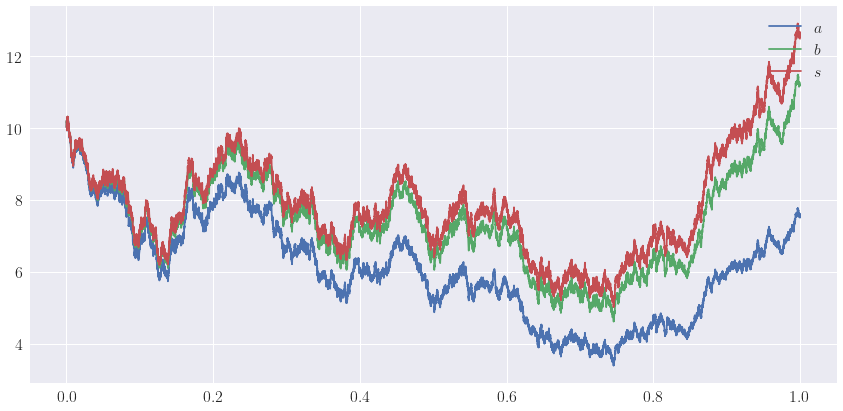

In [4]:
_ = plot_signals(
    [
        (t_a_nn, a_nn, "$a$", {}),
        (t_b_nn, b_nn, "$b$", {}),
        (signal_generator.x, signal_generator.y, "$s$", {}),
    ],
    legend="upper right",
)

## Mutual measurements

In [5]:
data_m = data[["t", "a", "b", "e_a", "e_b"]].dropna()
t_m = data_m["t"].values
a_m, b_m = data_m["a"].values, data_m["b"].values
e_a_m, e_b_m = data_m["e_a"].values, data_m["e_b"].values

pprint("Time", level=0)
pprint("- " + "t", t.shape, level=1)

pprint("Signal", level=0)
pprint("- a", a.shape, np.sum(~np.isnan(a)), level=1)
pprint("- a_m", a_m.shape, level=1)
pprint("- e_a", e_a_m.shape, level=1)

pprint("Signal", level=0)
pprint("- b", b.shape, np.sum(~np.isnan(b)), level=1)
pprint("- b_m", b_m.shape, level=1)
pprint("- e_b", e_b_m.shape, level=1)

Time                                              
    - t                                           (100000,)
Signal                                            
    - a                                           (100000,)    98974
    - a_m                                         (20044,)
    - e_a                                         (20044,)
Signal                                            
    - b                                           (100000,)    20254
    - b_m                                         (20044,)
    - e_b                                         (20044,)


## Degradation Correction

In [6]:
model = load_model(degradation_model)
model.initial_fit(a_m, b_m, e_a_m)

a_m_c, b_m_c, model, history = correct_degradation(
    t_m,
    a_m,
    e_a_m,
    b_m,
    e_b_m,
    model=model,
    method=correction_method,
)

d_a_c = model(e_a_nn)
d_b_c = model(e_b_nn)
a_c_nn = np.divide(a_nn, d_a_c)
b_c_nn = np.divide(b_nn, d_b_c)

## Results

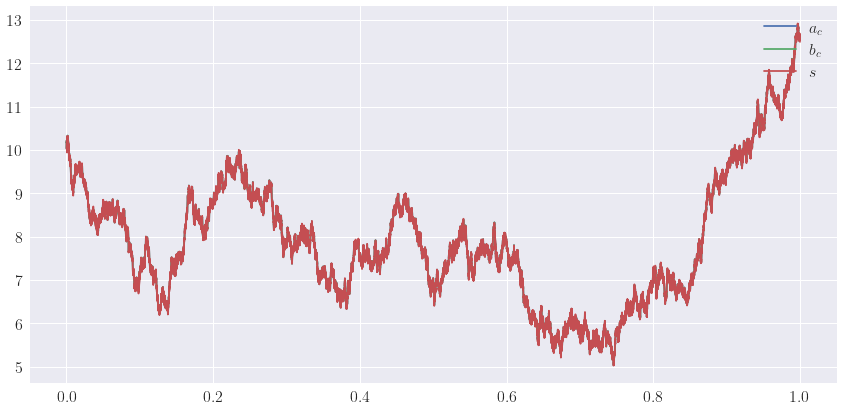

In [7]:
_ = plot_signals(
    [
        (t_m, a_m_c, "$a_c$", {}),
        (t_m, b_m_c, "$b_c$", {}),
        (signal_generator.x, signal_generator.y, "$s$", {}),
    ],
    legend="upper right",
)

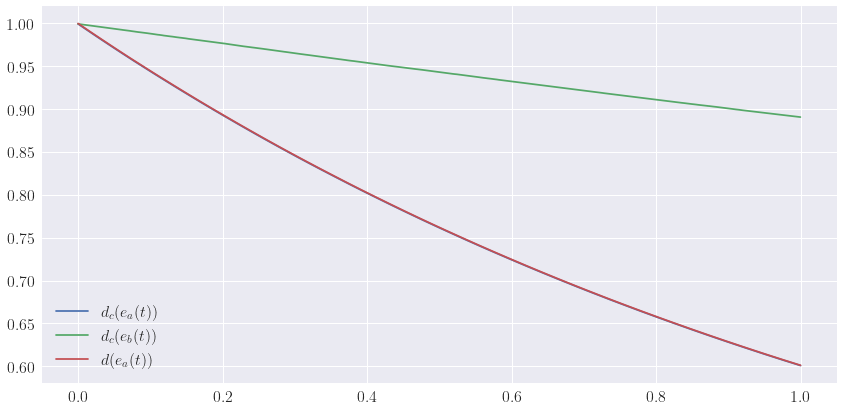

In [8]:
_ = plot_signals(
    [
        (t_a_nn, d_a_c, "$d_c(e_a(t))$", {}),
        (t_b_nn, d_b_c, "$d_c(e_b(t))$", {}),
        (
            t_a_nn,
            signal_generator.degradation_model(e_a_nn),
            "$d(e_a(t))$",
            {},
        ),
    ],
    legend="lower left",
)

### Correction History

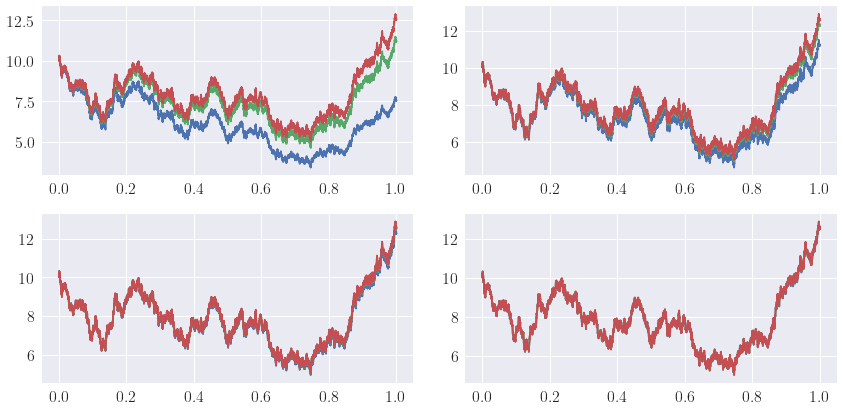

In [9]:
_ = plot_signals_history(
    t_m,
    [
        [
            (signals.a, "$a_{}$".format(i)),
            (signals.b, "$b_{}$".format(i)),
            (
                signal_generator.y[
                    np.logical_and(
                        signal_generator.get_indices_nn("a"),
                        signal_generator.get_indices_nn("b"),
                    )
                ],
                "$s$",
            ),
        ]
        for i, signals in enumerate(history[:4])
    ],
    n_rows=2,
    n_cols=2,
    tight_layout=True,
)